In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
import string
import validators as val
import seaborn as sb
from yake import KeywordExtractor
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, BatchNormalization, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

en_model = spacy.load('en_core_web_md')

In [2]:
df = pd.read_csv('train.csv',encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


0    4342
1    3271
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='count'>

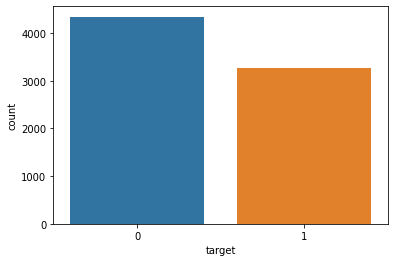

In [3]:
# check target class counts
print(df.target.value_counts())
sb.countplot(x=df.target)

In [4]:
# check for missing data
for col in df.columns:
    if df[col].isnull().mean()>0:
        print(col,df[col].isnull().mean())

keyword 0.008012610009194798
location 0.33272034677525286


In [5]:
# drop location column and fill keyword column with the mode value
df = df[['text','target','keyword']].fillna('nill')

In [6]:
# clean keyword column
def clean_keyword(x):
    x = x.replace('%20',' ')
    tok = en_model(x)
    tok = [str(x.lemma_) for x in tok]
    return ' '.join(tok)

df.keyword = df.keyword.apply(lambda x: clean_keyword(x))

In [7]:
# text cleaning function
# removes numbers, URLs, stopwords, punctuations and twitter handles

def clean_text(text):
    toks = text.split()
    toks = [t for t in toks if not val.url(t) and '@' not in t]
    toks = ' '.join(toks)
    for p in string.punctuation:
        if p not in ('#','@'):
            toks = toks.replace(p,' ')
    
    toks = toks.lower().split()
    toks = [t for t in toks if '@' not in t]
    toks = en_model(" ".join(toks))
    toks = [t for t in toks if str(t)!="'s"]
    toks = [t for t in toks if not t.is_stop and not t.is_digit]
    toks = [str(t) for t in toks if len(str(t))>1]
    return ' '.join(toks)

In [8]:
# original vs cleaned
for _ in range(5):
    i = np.random.randint(0,len(df))
    print('Original : '+df.text[i]+'\nCleaned : '+clean_text(df.text[i]))
    print('target :',df.target[i])
    print()

Original : Crushed the gym then crushed a butterfinger flurry clearly my priorities are straight ??
Cleaned : crushed gym crushed butterfinger flurry clearly priorities straight
target : 0

Original : I blew up snapchat for no reason ??
Cleaned : blew snapchat reason
target : 0

Original : Coastal German Shepherd Rescue OC shared a link: 'Ecstatic Rescued Racco... http://t.co/t8Q6DzVgwX #animalrescue
Cleaned : coastal german shepherd rescue oc shared link ecstatic rescued racco animalrescue
target : 0

Original : @JimMozel puck=flattened ball lol
Cleaned : puck flattened ball lol
target : 0

Original : Why does it say Silas sliced in that headlinelike someone chopped him up like a piece of cabbage????????????????????????  #GH
Cleaned : silas sliced headlinelike chopped like piece cabbage gh
target : 0



<AxesSubplot:xlabel='word_count', ylabel='Count'>

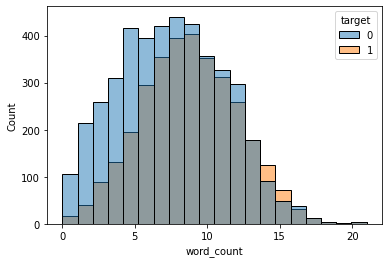

In [9]:
# clean tweet 
df['clean_text'] = df.text.apply(lambda x: clean_text(x))

# get word count of each tweet after cleaning
df['word_count'] = df.clean_text.apply(lambda x: len(x.split()))

# distribution of word count
sb.histplot(data=df,x='word_count',hue='target',bins=20)

In [10]:
# 0.8% of the values in the keyword column are missing.
# impute with the extracted keywords from the cleaned text

for i in df[df.keyword=='nill'].index:
    text = df.clean_text[i]
    ex = KeywordExtractor(n=1)
    kw = ex.extract_keywords(text)
    kw = [k[0] for k in kw if k[0] in df.keyword.unique()]
    if len(kw)>0:
        df.keyword.loc[i] = kw[0]
    else:
        df.keyword.loc[i] = df.keyword.mode()[0]  

C:\Users\BJS\AppData\Local\Temp\ipykernel_2408\1585185542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_2408\1585185542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode()[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_2408\1585185542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\BJS\

C:\Users\BJS\AppData\Local\Temp\ipykernel_2408\1585185542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode()[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_2408\1585185542.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = kw[0]
C:\Users\BJS\AppData\Local\Temp\ipykernel_2408\1585185542.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.keyword.loc[i] = df.keyword.mode()[0

In [11]:
# average word count, minimum length and max length of disaster tweets
df[df.target==1].word_count.mean(),df[df.target==1].word_count.min(),df[df.target==1].word_count.max()

(8.857230204830326, 1, 21)

In [12]:
# average word count, minimum length and max length of non-disaster tweets
df[df.target==0].word_count.mean(),df[df.target==0].word_count.min(),df[df.target==0].word_count.max()

(7.66305849838784, 0, 20)

In [13]:
x = df.keyword + ' ' + df.clean_text #cleaned input text
y = df.target #target feature

# get length of max input length
maxlen = 0
for i in x:
    if len(i.split())>maxlen: maxlen=len(i.split())

# split data for training, testing and validation to (70:20:10)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.7)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,train_size=0.7)

In [14]:
# tokenizing and padding

tk = Tokenizer()
tk.fit_on_texts(x)

seq = tk.texts_to_sequences(xtrain)
xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xval)
xval = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xtest)
xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

x_voc = len(tk.word_counts)+1

xtrain.shape,xval.shape,xtest.shape

((5329, 23), (686, 23), (1598, 23))

In [15]:
# load glove vectors
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
 
glove_embeddings = load_glove_model("D:/glove.6B.300d.txt")

Loading Glove Model
400000 words loaded!


In [16]:
# create pretrained embedding matrix
emb = np.zeros((x_voc,300))
for w,idx in tk.word_index.items():
    try: emb[idx] = glove_embeddings[w]
    except: pass

In [17]:
# linear attetion layer
class LinearAttention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)
        super().build(input_shape)
 
    
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context


In [18]:
# classification model

class TweetClassificationModel(tf.keras.models.Model):
    def __init__(self,rnn_units,vocab_size,embedding_weights,emb_dim,**kwargs):
        super().__init__(**kwargs)
        self.rnn_units=rnn_units
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.embedding_weights = embedding_weights
    
    def build(self,input_shape):
        self.emb = Embedding(self.vocab_size,self.emb_dim,weights=[self.embedding_weights])
        self.lstm = LSTM(self.rnn_units,return_sequences=True)
        self.dense = Dense(100,activation='relu')
        self.dropout = Dropout(0.1)
        self.attn = LinearAttention()
        self.out_put = Dense(1,activation='sigmoid')
        self.bn = BatchNormalization()
        super().build(input_shape)
    
    def call(self,x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.attn(x)
        x = self.dense(x)
        x = self.dropout(x)
        x = self.bn(x)
        return self.out_put(x)
    
    def summary(self,input_len):
        x = Input(shape=(input_len,))
        m = Model(x,self.call(x))
        return m.summary()
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'rnn_units':self.rnn_units,
            'vocab_size':self.vocab_size,
            'emb_dim':self.emb_dim,
            'embedding_weights':self.embedding_weights})
        return config
    

    

In [19]:
# initiate and build model

model = TweetClassificationModel(rnn_units=200,
                                vocab_size=x_voc,
                                embedding_weights=emb,
                                emb_dim=300)

model.build((None,maxlen))

model.summary(maxlen)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding (Embedding)       (None, 23, 300)           4332600   
                                                                 
 lstm (LSTM)                 (None, 23, 200)           400800    
                                                                 
 linear_attention (LinearAtt  (None, 200)              223       
 ention)                                                         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                             

In [20]:

loss_func = tf.keras.losses.BinaryCrossentropy() #binary_crossentropy loss
acc_func = tf.keras.metrics.BinaryAccuracy() #binary_accuracy
optimizer = Adam(learning_rate=1e-5) #adam optimizer


In [21]:
@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        pred = model(x, training=True)
        loss = loss_func(y,pred)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients,model.trainable_weights))
    acc_func.update_state(y,pred)
    return loss

@tf.function
def validation_step(x,y):
    pred = model(x, training=False)
    loss = loss_func(y,pred)
    acc = acc_func.update_state(y,pred)
    return loss

In [22]:
def train_model(epochs,trainin_data,validation_data,verbose=False, save_weights=True, filename='best_weights',batch_size=32):
    
    train = tf.data.Dataset.from_tensor_slices(trainin_data).batch(batch_size)
    val = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)
    
    metrics = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}
    
    val_loss, train_loss = 0, 0

    for e in range(epochs):
        if not verbose:
            print(f'Epochs = {e+1}/{epochs}')
        for i,(x,y) in enumerate(tqdm(train,disable=verbose)):
            loss = train_step(x,y)
            train_loss += loss
        
        train_loss = train_loss.numpy()/(i+1)
        train_acc = float(acc_func.result().numpy())
        acc_func.reset_states()
        
        for i,(x,y) in enumerate(val):
            loss = validation_step(x,y)
            val_loss += loss
        
        val_loss = val_loss.numpy()/(i+1)
        val_acc = float(acc_func.result().numpy())
        acc_func.reset_states()
        
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
    
        if save_weights and e+1>1:
            if min(metrics['val_loss'][:-1]) > val_loss:
                model.save_weights(filename)
        
        if not verbose :   
            print(f'train_loss = {np.round(train_loss,4)}  train_acc = {np.round(train_acc,4)}  '\
                  f'val_loss = {np.round(val_loss,4)}  val_acc = {np.round(val_acc,4)}\n')
        
        val_loss = 0
        train_loss = 0
        
    return metrics
        
        
    

In [23]:
# train model and get metrics

metrics = train_model(epochs=30,
                         trainin_data=(xtrain,ytrain),
                         validation_data=(xval,yval))

Epochs = 1/30


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:04<00:00, 38.93it/s]


train_loss = 0.6753  train_acc = 0.5922  val_loss = 0.667  val_acc = 0.6745

Epochs = 2/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 101.85it/s]


train_loss = 0.5426  train_acc = 0.7252  val_loss = 0.6033  val_acc = 0.7508

Epochs = 3/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 101.87it/s]


train_loss = 0.5022  train_acc = 0.7617  val_loss = 0.5183  val_acc = 0.7815

Epochs = 4/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.23it/s]


train_loss = 0.4825  train_acc = 0.7795  val_loss = 0.4721  val_acc = 0.7928

Epochs = 5/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.92it/s]


train_loss = 0.4657  train_acc = 0.79  val_loss = 0.4591  val_acc = 0.7989

Epochs = 6/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.60it/s]


train_loss = 0.4503  train_acc = 0.7969  val_loss = 0.4533  val_acc = 0.8017

Epochs = 7/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.66it/s]


train_loss = 0.4415  train_acc = 0.8029  val_loss = 0.4488  val_acc = 0.806

Epochs = 8/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.14it/s]


train_loss = 0.4333  train_acc = 0.8062  val_loss = 0.4445  val_acc = 0.8103

Epochs = 9/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.92it/s]


train_loss = 0.4214  train_acc = 0.8131  val_loss = 0.4403  val_acc = 0.8145

Epochs = 10/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 101.67it/s]


train_loss = 0.4154  train_acc = 0.8193  val_loss = 0.4378  val_acc = 0.8159

Epochs = 11/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.42it/s]


train_loss = 0.4094  train_acc = 0.8193  val_loss = 0.436  val_acc = 0.8159

Epochs = 12/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.23it/s]


train_loss = 0.4036  train_acc = 0.8268  val_loss = 0.4339  val_acc = 0.8231

Epochs = 13/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 101.30it/s]


train_loss = 0.3966  train_acc = 0.8311  val_loss = 0.4331  val_acc = 0.8231

Epochs = 14/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 101.36it/s]


train_loss = 0.3913  train_acc = 0.8324  val_loss = 0.4318  val_acc = 0.8245

Epochs = 15/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.00it/s]


train_loss = 0.3873  train_acc = 0.835  val_loss = 0.4301  val_acc = 0.8245

Epochs = 16/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.10it/s]


train_loss = 0.3787  train_acc = 0.8416  val_loss = 0.4295  val_acc = 0.8245

Epochs = 17/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.01it/s]


train_loss = 0.3768  train_acc = 0.8415  val_loss = 0.4289  val_acc = 0.8231

Epochs = 18/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.58it/s]


train_loss = 0.3694  train_acc = 0.8444  val_loss = 0.4287  val_acc = 0.8231

Epochs = 19/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.81it/s]


train_loss = 0.3635  train_acc = 0.8483  val_loss = 0.4282  val_acc = 0.8231

Epochs = 20/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.41it/s]


train_loss = 0.357  train_acc = 0.8511  val_loss = 0.4283  val_acc = 0.8231

Epochs = 21/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.35it/s]


train_loss = 0.3552  train_acc = 0.8518  val_loss = 0.4283  val_acc = 0.8216

Epochs = 22/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.54it/s]


train_loss = 0.3521  train_acc = 0.8522  val_loss = 0.4285  val_acc = 0.8202

Epochs = 23/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.10it/s]


train_loss = 0.3467  train_acc = 0.8534  val_loss = 0.4289  val_acc = 0.8174

Epochs = 24/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 102.35it/s]


train_loss = 0.3403  train_acc = 0.8593  val_loss = 0.429  val_acc = 0.8159

Epochs = 25/30


100%|███████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 101.85it/s]


train_loss = 0.334  train_acc = 0.8657  val_loss = 0.4293  val_acc = 0.8159

Epochs = 26/30


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 99.02it/s]


train_loss = 0.334  train_acc = 0.8633  val_loss = 0.4305  val_acc = 0.8131

Epochs = 27/30


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 99.85it/s]


train_loss = 0.3304  train_acc = 0.8653  val_loss = 0.4307  val_acc = 0.8159

Epochs = 28/30


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 99.37it/s]


train_loss = 0.323  train_acc = 0.8694  val_loss = 0.4311  val_acc = 0.8159

Epochs = 29/30


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 99.26it/s]


train_loss = 0.3192  train_acc = 0.8687  val_loss = 0.4327  val_acc = 0.8159

Epochs = 30/30


100%|████████████████████████████████████████████████████████████████████████████████| 167/167 [00:01<00:00, 99.67it/s]


train_loss = 0.3162  train_acc = 0.8691  val_loss = 0.4332  val_acc = 0.8159



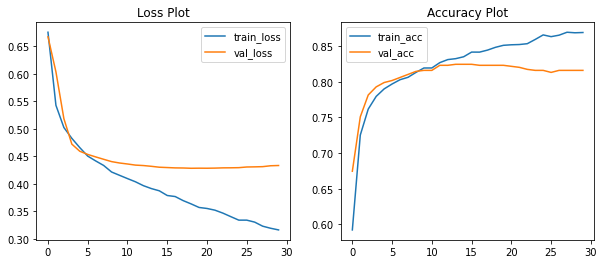

In [24]:
def plot_training_logs(metrics):
    metrics = pd.DataFrame(metrics)
    _,(ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
    metrics[['train_loss','val_loss']].plot(ax=ax1,title='Loss Plot')
    metrics[['train_acc','val_acc']].plot(ax=ax2,title='Accuracy Plot')
    plt.show()

plot_training_logs(metrics)

In [25]:
model = TweetClassificationModel(rnn_units=200,vocab_size=x_voc,embedding_weights=emb,emb_dim=300)
model.build((None,maxlen))
model.load_weights('best_weights')

def evaluate(x,y):
    pred = model(x,training = False)
    pred = np.round(pred.numpy().flatten())
    print(classification_report(y,pred))
    sb.heatmap(confusion_matrix(y,pred),annot=True,fmt='d',cmap='Blues')
    plt.show()

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       395
           1       0.82      0.75      0.78       291

    accuracy                           0.82       686
   macro avg       0.82      0.81      0.82       686
weighted avg       0.82      0.82      0.82       686



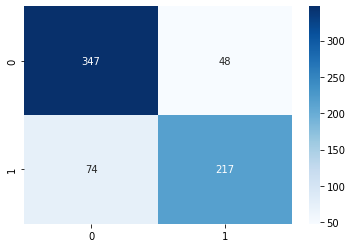

In [26]:
evaluate(xval,yval)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       912
           1       0.81      0.73      0.77       686

    accuracy                           0.81      1598
   macro avg       0.81      0.80      0.80      1598
weighted avg       0.81      0.81      0.81      1598



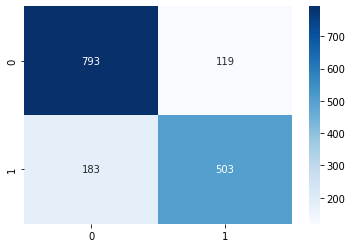

In [27]:
evaluate(xtest,ytest)

fold 1/5
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       868
           1       0.83      0.64      0.72       655

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523



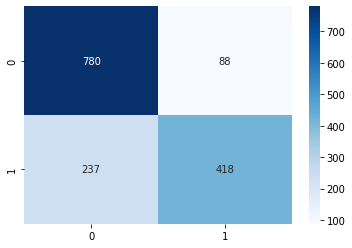

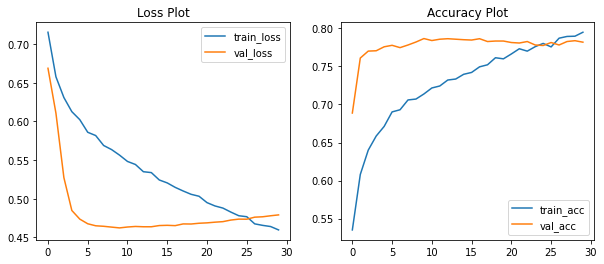


################################################

fold 2/5
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       869
           1       0.72      0.62      0.67       654

    accuracy                           0.73      1523
   macro avg       0.73      0.72      0.72      1523
weighted avg       0.73      0.73      0.73      1523



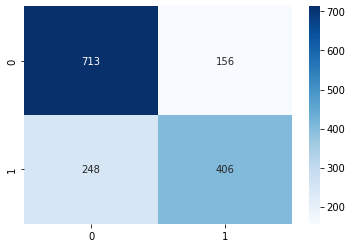

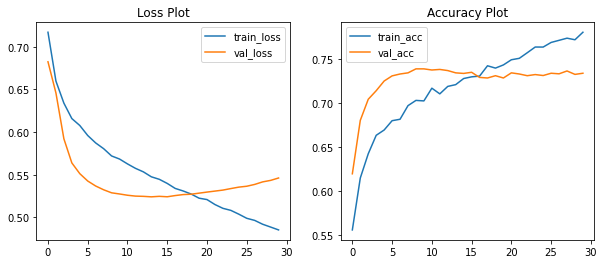


################################################

fold 3/5
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       869
           1       0.75      0.61      0.67       654

    accuracy                           0.74      1523
   macro avg       0.74      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



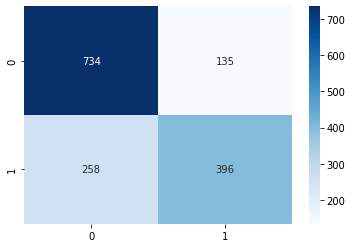

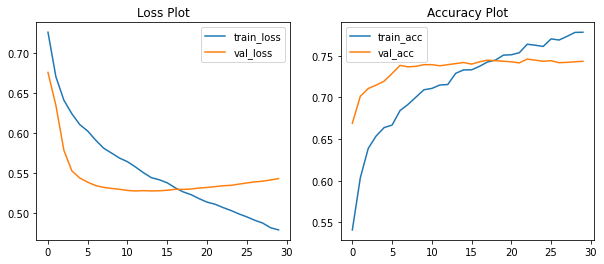


################################################

fold 4/5
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       868
           1       0.75      0.53      0.62       654

    accuracy                           0.72      1522
   macro avg       0.73      0.70      0.70      1522
weighted avg       0.73      0.72      0.71      1522



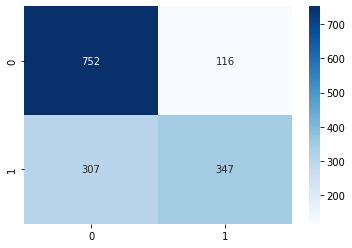

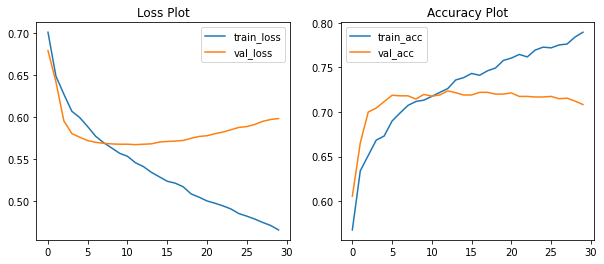


################################################

fold 5/5


In [ ]:
# cross-validation

n = 5
acc = 0
f1 = 0
sfk = StratifiedKFold(n_splits=n)
sfk.get_n_splits(x,y)
count=1
for train_idx,test_idx in sfk.split(x,y):
    xtrain,xtest = x[train_idx],x[test_idx]
    ytrain,ytest = y[train_idx],y[test_idx]
    
    tk = Tokenizer()
    tk.fit_on_texts(xtrain)

    seq = tk.texts_to_sequences(xtrain)
    xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

    seq = tk.texts_to_sequences(xtest)
    xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

    x_voc = len(tk.word_counts)+1
    
    emb = np.zeros((x_voc,300))
    for w,idx in tk.word_index.items():
        try: emb[idx] = glove_embeddings[w]
        except: pass
    
    model = TweetClassificationModel(rnn_units=200,
                                vocab_size=x_voc,
                                embedding_weights=emb,
                                emb_dim=300)

    model.build((None,maxlen))
    
    loss_func = tf.keras.losses.BinaryCrossentropy()
    acc_func = tf.keras.metrics.BinaryAccuracy()
    optimizer = Adam(learning_rate=1e-5)
    
    @tf.function
    def train_step(x,y):
        with tf.GradientTape() as tape:

            pred = model(x, training=True)

            loss = loss_func(y,pred)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients,model.trainable_weights))
        acc_func.update_state(y,pred)
        return loss

    @tf.function
    def validation_step(x,y):
        pred = model(x, training=False)
        loss = loss_func(y,pred)
        acc = acc_func.update_state(y,pred)
        return loss
    
    print(f'fold {count}/{n}')
    metrics = train_model(epochs=30,
                         trainin_data=(xtrain,ytrain),
                         validation_data=(xtest,ytest),
                         verbose=True, filename='fold_best_weights')
    
    model.load_weights('fold_best_weights')
    
    evaluate(xtest,ytest)
    plot_training_logs(metrics)
    
    pred = model(xtest,training=False)
    pred = np.round(pred.numpy().flatten())
    
    f1 += f1_score(ytest,pred)
    acc += accuracy_score(ytest,pred)
    
    print("\n################################################\n")
    
    count+=1
    
print('avg f1-score :',f1/n)
print('avg accuracy :',acc/n)